# Merging (and Unmerging) probability values

In quantum computing, it is common to end up with extremely large probability vectors, with relatively few states being *interesting* (having non-zero values).
Dealing with the entire probability vector is thus not only memory-intensive, but also unhelpful in analysis/visualization (try plotting a 2^30 probability vector - not only will you run out of memory, you'll see nothing in the resulting plot). The problem is compounded when these individually large probability vectors are combined (taking a Kronecker product of these vectors, for example, as is one in the `cutqc2` codebase).

This notebook introduces the `merge_prob_vector` (and the corresponding `unmerge_prob_vector`) functions, the building blocks of classical postprocessing using `cutqc2`.

## Merging

The `merge_prob_vector` function in `cutqc2.utils` takes in a probability vector and a `qubit_spec` - a string with characters that mean something specific:
  - `A` - keep this qubit *active*, i.e. treat it as normal
  - `M` - *merge* this qubit, i.e. sum the probability values for cases when this qubit is either 0 or 1. This effectively compresses multiple states into bins.
  - `0` - only consider cases when this qubit is `0`, otherwise, ignore them.
  - `1` - only consider cases when this qubit is `1`, otherwise, ignore them.

The merge operation thus returns a new probability vector (of length <= the original uncompressed vector), allowing us *zoomed-in* access to probability values.

## Unmerging

The `unmerge_prob_vector` function does the opposite. It takes a compressed probability vector, the `qubit_spec` used to create it, and *spreads* the values across all possible states, distributing probability mass evenly when it needs to.

The unmerge operation thus returns a new probability vector (of length >= the compressed vector), allowing us *zoomed-out* access to probability values.

`unmerge_prob_vector` is obviously a *lossy* operation (since it assumes an even distribution between possible states), and cannot recover the original probability distribution.

The combined effect of merging/unmerging is that we get a *blurred* representation of the probability distribution.

Let's see these in action.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cutqc2.core.utils import merge_prob_vector, unmerge_prob_vector

Create a length 32 (5 bit) probability vector using numpy, and plot it.

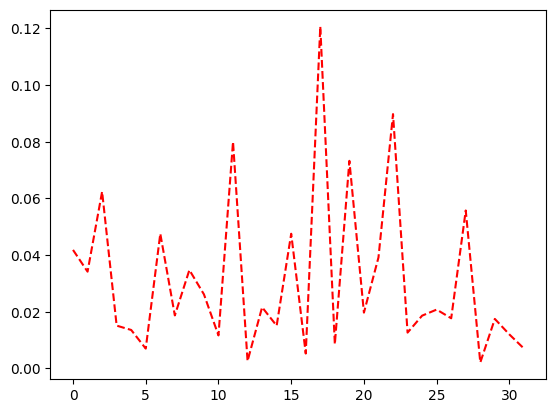

In [2]:
full_distribution = np.random.dirichlet(np.ones(32), size=1)[0]

plt.plot(range(len(full_distribution)), full_distribution, linestyle="--", color="r")

Let's create a function that takes in the original distribution, a `qubit_spec`, and plots the distribution as well as the blurred representation of it (by merging and unmerging using the same `qubit_spec`).

In [3]:
def plot(dist, qubit_spec: str):
    # Plot original distribution
    plt.plot(range(len(dist)), dist, linestyle="--", color="r")

    # Plot coarse-grained distribution
    dist = unmerge_prob_vector(merge_prob_vector(dist, qubit_spec), qubit_spec)
    plt.bar(range(len(dist)), dist)
    plt.title(qubit_spec)
    plt.show()

Look at the different plots we get for differing values of `qubit_spec`s, going from all merged qubits (`MMMMM`) to all active (`AAAAA`). The more active qubits we have in our `qubit_spec`, the better the reconstructed distribution approximates the original distribution.

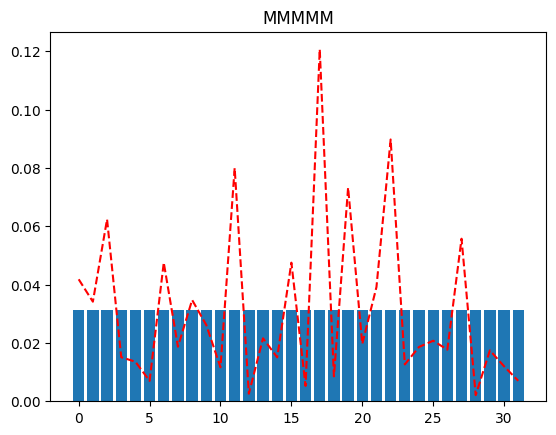

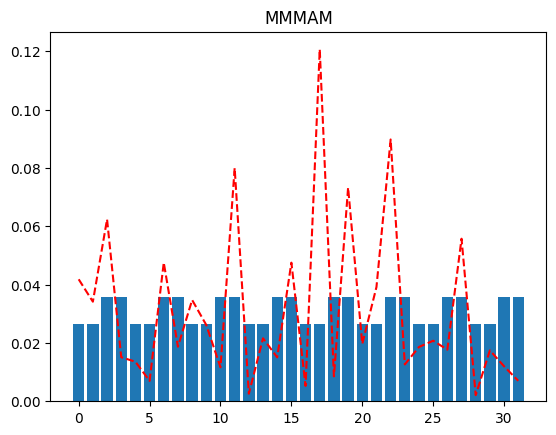

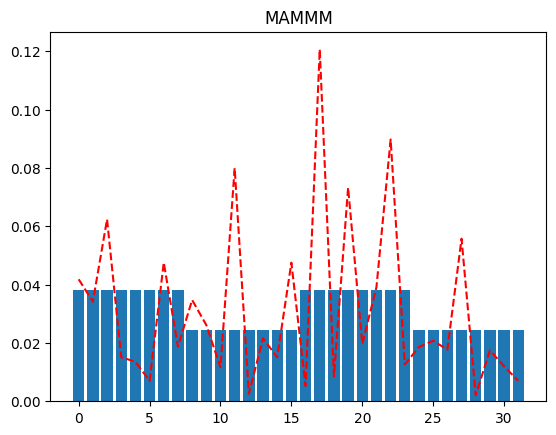

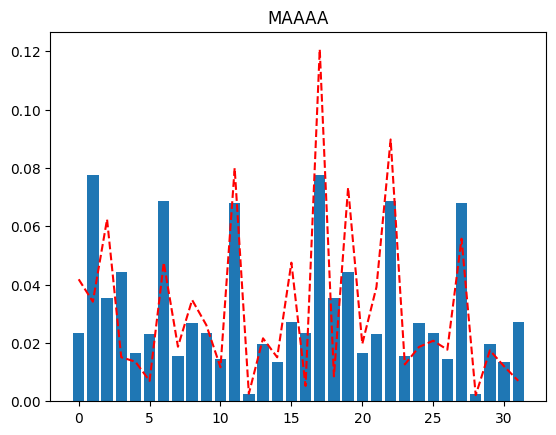

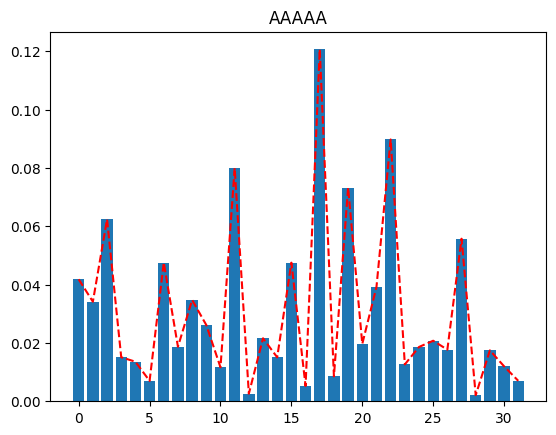

In [4]:
plot(full_distribution, "MMMMM")

plot(full_distribution, "MMMAM")
# note that the location of the active qubits matter.
# The following is not the same case as above.
plot(full_distribution, "MAMMM")

plot(full_distribution, "MAAAA")
plot(full_distribution, "AAAAA")

If we were peeking into the distribution using just a single qubit resolution, we might, as an example, try to plot the distribution when the MSB is 0 (and the rest of the qubits are merged), and again when the MSB is 1 (and the rest of the qubits are merged). This will tell us which half of the distribution has more probability mass (for further investigation).

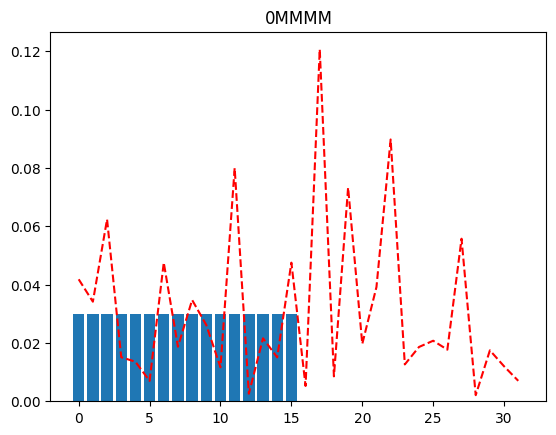

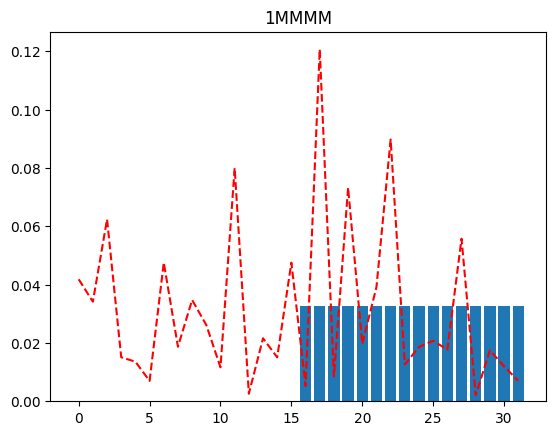

In [5]:
plot(full_distribution, "0MMMM")
plot(full_distribution, "1MMMM")

### Doesn't unmerging undermine the whole point of doing all of this?

It is absolutely correct that unmerging like we're naively doing here brings us back to the regime of `2^num_qubits` address space. All the bar plots above have 32 bins after all. However, this is done here only for illustrative purposes. We will typically be using the `unmerge_prob_vector` function by passing in another argument, `full_states`, which is an `ndarray` of state values we're interested in exploring.

Let us modify our `plot` function so it takes a `full_states` argument that we pass on to `unmerge_prob_vector`. We'll call it `selective_plot`.

In [6]:
def selective_plot(dist, qubit_spec: str, full_states: np.ndarray):
    # Plot original distribution
    plt.plot(range(len(dist)), dist, linestyle="--", color="r")

    # Plot coarse-grained distribution
    dist = unmerge_prob_vector(
        merge_prob_vector(dist, qubit_spec), qubit_spec, full_states
    )
    plt.bar(range(len(dist)), dist)
    plt.title(qubit_spec)
    plt.show()

With this function, if we choose to work with 4 qubits (i.e. one merged and 4 active), we can choose to only expand the second half of the unmerged plot.

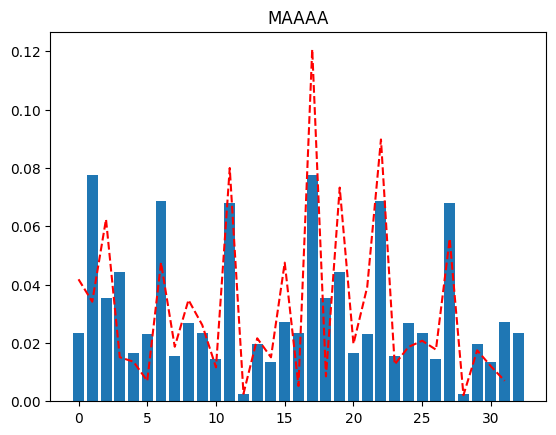

In [7]:
selective_plot(full_distribution, "MAAAA", np.arange(32, 65))

## Conclusion

We're now effectively able to approximate the original distribution of 5 qubits with a memory space of 4 qubits. The quality of the approximation may not be great (we'll never know since we don't have access to the original distribution - the dashed red lines in this toy example). That's where the `DynamicDefinition` class comes in!